In [1]:
# script to plot standard .las files
# most of the heavy lifting done with lasio and welly (github)


In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

from welly import Well
from bruges import petrophysics as pet


In [468]:
def get_top_bottom_depth(X, low, high):
    
    idxs = np.where(np.logical_and(X >= low, X <= high))[0]
    return idxs[0], idxs[-1]

In [469]:
def get_curve_params(lw=2.0):
    """
    Because we are removing things from the dictionary and I don't want to re-run
    this cell each time.
    """
    
    line_styles = {
               'GR': {'data': w.data['GR'] ,'name':'Gamma Ray', 'lw': lw, 
                      'color':'darkgreen', 'label':'GR', 'units':'API',
                      'xlim': (0,150)
                      },
               'SP': {'data': w.data['SP'] ,'name':'Spont. Pot.', 'lw': lw,
                      'color':'purple',
                      'label':'SP', 
                      'units': 'mV',},
               'RDEP': {'data': w.data['RDEP'],'name':'Deep Res.', 'lw': lw, 
                       'color':'black','label':'Deep Resitivity',
                       'xlim':(0.2,200),
                       'units':'ohm.m', 
                       'xticks':(1,10,100)}, 
               'RSHAL': {'data': w.data['RSHAL'],'name':'Shallow Res.', 'lw': lw, 
                       'color':'darkgrey','label':'Shallow Resitivity',
                       'xlim':(0.2,200),
                       'units':'ohm.m', 
                       'xticks':(1,10,100)}, 
               'NPHI': {'data': w.data['NEUT'],'name':'Neutron Por.', 'lw': lw, 
                        'color': 'darkblue', 'label':'NPHI', 'units': 'V/V',
                        'xlim': (0.6,-0.1), 'xticks':np.arange(0.0,0.7,0.2)},
               'RHOB': {'data': w.data['DENS'],'name':'Bulk Dens.','lw': lw, 
                        'color': 'red', 'label':'Bulk Density', 'units':'kg/m^3',
                        'xlim':(2.15, 2.75)},
               'DPHI': {'data': w.data['DPHI'],'name':'Density Por.','lw': lw, 
                        'color': 'red', 'label':'Density Porosity', 'units':'V/V',
                        'xlim':(0.6, -0.1)}
              }
    return line_styles

In [489]:
def make_nice_yticks(upper, lower, inc=10):
    """
    returns a nice round numbers based on plot range to 
    set nice y-ticklabels
    """
    nice_upper = inc*np.ceil(upper/inc)
    nice_lower = inc*np.floor(lower/inc)
    return np.arange(nice_upper, nice_lower, inc)

In [495]:
def plot_curve_in_linear_track(ax, mnemonic, curve_dict, name, units, grid=False, 
                               yticklabels=False, rightmost=False, secondary=False):
    """
    Takes and axis, a mnemonic, and curve dictionary and makes a plot
    """
    if 'xlim' in curve_dict[mnemonic]:
        xlims = curve_dict[mnemonic].pop('xlim')
        ax.set_xlim(xlims)
    if 'xticks' in curve_dict[mnemonic]:
        xticks = curve_dict[mnemonic].pop('xticks')
        ax.set_xticks(xticks)
    
    if secondary:
        j = 5
    else:
        j = 1
        
    ax.set_xlabel(f'{name} ({units})', size=fontsize, 
                      color=curve_dict[mnemonic]['color'], labelpad=j*labelpad)
    
    ax.tick_params(axis='x', labelcolor=curve_dict[mnemonic]['color'])
    
    ax.xaxis.set_label_position('top')
    ax.tick_params(which='minor', length=minor_tick_len, width=1, direction='in')
    ax.yaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y',which='minor', length=minory_tick_len, width=1, direction='in', color='lightgrey')
    
    if not yticklabels:
        ax.axes.get_yaxis().set_ticklabels([])
        
    if rightmost:
        ax.tick_params(labelright=True, labelleft=False)
    
    nice_yrange = make_nice_yticks(upper, lower, md_inc)
    ax.yaxis.set_ticks(nice_yrange)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    ax.set_ylim(nice_yrange[0], nice_yrange[-1])

    if not secondary:
        ax.invert_yaxis()
    
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['top'].set_color(spine_color) 
    ax.spines['right'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.yaxis.label.set_color(spine_color)
    [t.set_color(spine_color) for t in ax.yaxis.get_ticklines()]
    [t.set_color(spine_color) for t in ax.xaxis.get_ticklines()]
    if grid:
        ax.grid(True)
    # Finally, 
    ax.plot(np.convolve(smooth_window, curve, mode='same'), depth,
            '-', **curve_dict[mnemonic])

        
    return ax

In [496]:
def plot_curve_in_logarithmic_track(ax, mnemonic, curve_dict):
    """
    Takes and axis, a mnemonic, and curve dictionary and makes a plot
    """

    for i,m in enumerate(mnemonic):
        if curve_dict[m]['xlim']:
            xlims = curve_dict[m].pop('xlim')
            ax.set_xlim(xlims)
        
        xticks = curve_dict[m].pop('xticks')
        units, curve, depth, name = get_curve(m, curve_dict, itop, ibase)
        ax.semilogx(np.convolve(smooth_window, curve, mode='same'), depth, zorder=10000+i,
                    **curve_dict[m], )
        ax.text(0.5, 1.0535+((i-1)*label_shift), f'{name} ({units})', 
             size=fontsize,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             color=curve_dict[m]['color'])
    
    nice_yrange = make_nice_yticks(upper, lower, md_inc)
    ax.yaxis.set_ticks(nice_yrange)
    ax.set_ylim(nice_yrange[0], nice_yrange[-1])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))    
    ax.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
    
    # minor gridlines
    for xmin in ax.xaxis.get_minorticklocs():
        ax.axvline(x=xmin, ls='-', c='k', alpha=0.5, lw=0.15)
    ax.set_xticks(xticks)
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(labeltop=True, labelbottom=True)
    ax.set_xlim(xlims)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y',which='minor', length=minory_tick_len, width=1, direction='in', color='lightgrey')
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['top'].set_color(spine_color) 
    ax.spines['right'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.yaxis.label.set_color(spine_color)
    [t.set_color(spine_color) for t in ax.yaxis.get_ticklines()]
    [t.set_color(spine_color) for t in ax.xaxis.get_ticklines()]
    ax.invert_yaxis()
    ax.grid(True)
    return ax

In [497]:
def get_curve(mnemonic, curve_dict, itop, ibase):
    """
    returns units, curve data, depth data, 
    and curve name over a specific depth inteval of interest
    """
    name = curve_dict[mnemonic].pop('name')
    units = curve_dict[mnemonic].pop('units')
    curve = curve_dict[mnemonic].pop('data')
    depth = curve.basis
    return units, curve[itop:ibase], depth[itop:ibase], name

# Getting the data and setting some parameters


In [518]:
datafile="204-20-2_logs.las" # want to loop over all *.las files in folder in the future
w = Well.from_las(datafile)
dphi = pet.density_to_porosity(w.data['DENS']*1000.0, rho_matrix=2650, rho_fluid=1000)
w.data['DPHI'] = dphi

#These are the only things I want to change
itop, ibase = get_top_bottom_depth(w.data['DENS'].basis, upper, lower)
upper, lower = 1797, 2627
fontsize = 12
labelpad = 10  # for second x-axis label above the first 
label_shift = 0.023  # For single axis and multiple tracks (like sonics or resisitivity)
minory_tick_len = 4
minorx_tick_len = 3
nsmooth = 15 # number of samples to smooth
smooth_window = np.ones(nsmooth)/nsmooth
majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(5)
spine_color = 'lightgrey'
spacing_between_tracks = 0.1
figwidth, figheight = (7,18)
md_inc = 25

# Finally call the function to make the dicationary
line_styles = get_curve_params()


Header section Parameter regexp=~P was not found.


# Doing the plot:

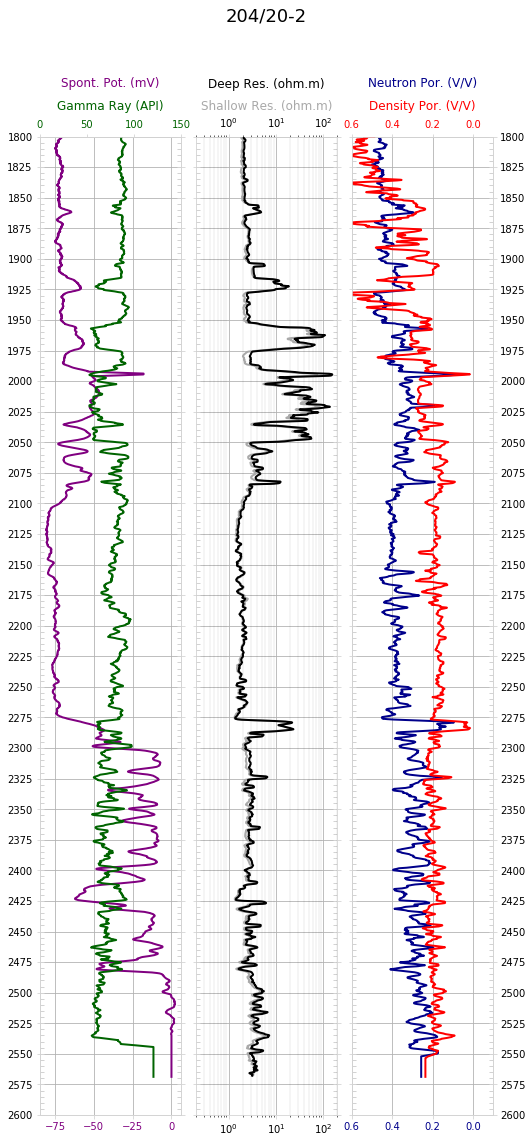

In [519]:
# Lets plot this bad boy (must re-run the cell above to run this over and over again)
fig = plt.figure(figsize=(figwidth, figheight))
fig.suptitle(w.header.name, fontsize=18) 
gs1 = GridSpec(3, 3)
gs1.update(left=0.05, right=0.95, wspace=spacing_between_tracks)
ax1 = plt.subplot(gs1[:, 0])
ax2 = plt.subplot(gs1[:, 1])
ax3 = plt.subplot(gs1[:, 2])

# Gamma & SP Track
units, curve, depth, name = get_curve('SP', line_styles, itop, ibase)
ax1 = plot_curve_in_linear_track(ax1, 'SP', line_styles, name, units, 
                                 grid=True, yticklabels=True, secondary=True)

units, curve, depth, name = get_curve('GR', line_styles, itop, ibase)
ax4 = ax1.twiny() 
ax4 = plot_curve_in_linear_track(ax4, 'GR', line_styles, name, units, 
                                 grid=False, yticklabels=True, secondary=False)

# Resistivity Track
ax2 = plot_curve_in_logarithmic_track(ax2, ['RSHAL','RDEP'], line_styles)


# Neutron Porosity and Bulk Density
units, curve, depth, name = get_curve('NPHI', line_styles, itop, ibase)
ax3 = plot_curve_in_linear_track(ax3, 'NPHI', line_styles, name, units, grid=True, 
                                 rightmost=True, yticklabels=True, secondary=True)
units, curve, depth, name = get_curve('DPHI', line_styles, itop, ibase)
ax6 = ax3.twiny()
ax6 = plot_curve_in_linear_track(ax6, 'DPHI', line_styles, name, units, 
                                 rightmost=True, yticklabels=True, secondary=False)

